In [1]:
import sys
import os

# Projektverzeichnis
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

# Füge dem sys.path hinzu, falls noch nicht vorhanden
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
# Datenzugriff
from models import db, Routing, Job, Schedule, JobOperation


# Utils
import src.utils.presenter as show
from src.utils.analize import check_constrains as check

from src.utils.production_process import time_determination as term
from src.utils.production_process import filter as process_filter

# Solver Model
from src.models.cp import lateness_scheduling as cp_late_schedule
from src.models.cp import lateness_rescheduling as cp_late_reschedule
import src.models.heuristics.fcfs as fcfs


# Simulation
from src.simulation.ProductionSimulation import ProductionSimulation

# Extern
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 21)

In [3]:
max_time = 60 * 30 # 30 min

## Laden der Produktionsaufträge

In [4]:
df_jobs_times = Job.get_dataframe(version="lateness")
df_jobs_times

,Job,Routing_ID,Arrival,Ready Time,Deadline,Status,Version
0,J25-0000,8,79,1440,3660,open,lateness
1,J25-0001,6,129,1440,2338,closed,lateness
2,J25-0002,0,198,1440,3744,open,lateness
3,J25-0003,2,243,1440,3379,open,lateness
4,J25-0004,3,287,1440,4856,open,lateness
...,...,...,...,...,...,...,...
1188,J25-1188,8,85975,86400,88866,open,lateness
1189,J25-1189,1,86001,86400,88375,open,lateness
1190,J25-1190,5,86033,86400,87868,open,lateness
1191,J25-1191,1,86084,86400,88251,open,lateness


In [5]:
def get_jssp_for_jobs(df_jobs_times, df_routings):
    """
    Erstellt ein JSSP-kompatibles DataFrame durch Verknüpfung von Job-Zeitdaten mit Routings.

    Parameter:
    - df_jobs_times: DataFrame mit mindestens den Spalten 'Job' und 'Routing_ID'.
    - df_routings: DataFrame mit Spalte 'Routing_ID' und den zugehörigen Operationsdaten.

    Rückgabe:
    - df_jssp: DataFrame mit allen für das JSSP notwendigen Informationen, inklusive 'Job' und den Operationen.
    """
    # 1. Relevante Spalten extrahieren
    df_job_ids = df_jobs_times[['Job', 'Routing_ID']].copy()

    # 2. Merge mit df_routings über Routing_ID
    df_jssp = df_job_ids.merge(df_routings, on='Routing_ID')

    return df_jssp

# Routings
df_routings = Routing.get_dataframe()
df_jssp = get_jssp_for_jobs(df_jobs_times, df_routings)
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
...,...,...,...,...,...
11925,J25-1192,3,5,M08,52
11926,J25-1192,3,6,M07,85
11927,J25-1192,3,7,M03,98
11928,J25-1192,3,8,M09,22


## Laden der Initialisierungsdaten vom Tag 1

In [6]:
day_numb = 1

In [7]:
df_schedule = Schedule.get_schedule_as_dataframe(date = 1, version="lateness")
df_schedule

,Job,Routing_ID,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,J25-0005,1,0,M00,498,3106,1440,43,1483,-1623,0,1623
1,J25-0007,5,0,M02,925,2929,1440,84,1524,-1405,0,1405
2,J25-0013,3,0,M01,1192,2567,1440,81,1521,-1046,0,1046
3,J25-0011,1,0,M00,1030,3210,1483,43,1526,-1684,0,1684
4,J25-0001,6,0,M01,129,2338,1521,46,1567,-771,0,771
...,...,...,...,...,...,...,...,...,...,...,...,...
155,J25-0009,7,9,M03,1004,3578,3499,79,3578,0,0,0
156,J25-0000,8,9,M08,79,3660,3586,74,3660,0,0,0
157,J25-0002,0,9,M09,198,3744,3723,21,3744,0,0,0
158,J25-0012,2,9,M04,1103,4385,4352,33,4385,0,0,0


In [8]:
df_ops_in_progress = JobOperation.get_dataframe(version="lateness", status="in progress")
df_ops_in_progress

,Job,Machine,Operation,Start,End,Processing Time,Version,Operation Status
0,J25-0000,M07,7,2793.04,2886.95,93.91,lateness,in progress
1,J25-0004,M08,5,2847.61,2907.80,60.19,lateness,in progress
2,J25-0006,M04,8,2756.44,2891.60,135.16,lateness,in progress


In [9]:
#  JSSP zu allen "offenen" Jobs, mit "offenen" Operationen
unique_jobs = df_schedule.Job.unique().tolist()
df_plan_undone  = JobOperation.get_dataframe(version="lateness", jobs=unique_jobs, status="open")
df_plan_undone 

,Job,Machine,Operation,Start,End,Processing Time,Version,Operation Status
0,J25-0000,M04,8,None,None,26.0,lateness,open
1,J25-0000,M08,9,None,None,74.0,lateness,open
2,J25-0002,M09,9,None,None,21.0,lateness,open
3,J25-0003,M04,9,None,None,33.0,lateness,open
4,J25-0004,M07,6,None,None,85.0,lateness,open
5,J25-0004,M03,7,None,None,98.0,lateness,open
6,J25-0004,M09,8,None,None,22.0,lateness,open
7,J25-0004,M05,9,None,None,43.0,lateness,open
8,J25-0005,M08,9,None,None,30.0,lateness,open
9,J25-0006,M07,9,None,None,45.0,lateness,open


## Version simple

In [10]:
this_version = "lateness_simple"

In [11]:
# Jobs
Job.clone_jobs(referenced_version="lateness", new_version=this_version)

✅ 1193 Jobs von Version 'lateness' nach Version 'lateness_simple' kopiert.


In [12]:
JobOperation.clone_operations(referenced_version="lateness", new_version=this_version)

✅ 11930 JobOperation-Einträge von Version 'lateness' nach Version 'lateness_simple' kopiert.


In [13]:
Schedule.clone_schedules(referenced_version="lateness", new_version=this_version)

✅ 1 Schedule-Einträge von Version 'lateness' nach 'lateness_simple' kopiert.


In [14]:
def get_jssp_for_jobs(df_jobs_times, df_routings):
    """
    Erstellt ein JSSP-kompatibles DataFrame durch Verknüpfung von Job-Zeitdaten mit Routings.

    Parameter:
    - df_jobs_times: DataFrame mit mindestens den Spalten 'Job' und 'Routing_ID'.
    - df_routings: DataFrame mit Spalte 'Routing_ID' und den zugehörigen Operationsdaten.

    Rückgabe:
    - df_jssp: DataFrame mit allen für das JSSP notwendigen Informationen, inklusive 'Job' und den Operationen.
    """
    # 1. Relevante Spalten extrahieren
    df_job_ids = df_jobs_times[['Job', 'Routing_ID']].copy()

    # 2. Merge mit df_routings über Routing_ID
    df_jssp = df_job_ids.merge(df_routings, on='Routing_ID')

    return df_jssp

## Rolling Planning ab Tag 2

In [15]:
day_length = 1440

In [16]:
day_numb = 2

day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Day {day_numb:02d}: [{day_start}, {day_end})")


# alle aktuelle "offenen" Jobs
df_jobs_times_curr = Job.get_dataframe(version=this_version, arrival_time_max=day_start, status="open")
df_jobs_times_curr

Day 02: [2880, 4320)


,Job,Routing_ID,Arrival,Ready Time,Deadline,Status,Version
0,J25-0000,8,79,1440,3660,open,lateness_simple
1,J25-0002,0,198,1440,3744,open,lateness_simple
2,J25-0003,2,243,1440,3379,open,lateness_simple
3,J25-0004,3,287,1440,4856,open,lateness_simple
4,J25-0005,1,498,1440,3106,open,lateness_simple
...,...,...,...,...,...,...,...
31,J25-0033,2,2660,2880,6738,open,lateness_simple
32,J25-0034,8,2715,2880,6387,open,lateness_simple
33,J25-0035,5,2726,2880,4126,open,lateness_simple
34,J25-0036,4,2734,2880,5231,open,lateness_simple


In [17]:
#  JSSP zu allen "offenen" Jobs (auch fertige Operationen)
df_jssp_temp = get_jssp_for_jobs(df_jobs_times_curr, df_routings)


#  JSSP zu allen "offenen" Jobs, mit "offenen" Operationen
df_jobs_ops = JobOperation.get_dataframe(version=this_version, jobs=df_jssp_temp.Job.tolist(), status="open")
df_jssp_curr = df_jssp_temp.merge(df_jobs_ops[['Job', 'Operation']], on=['Job', 'Operation'], how='inner')
df_jssp_curr

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,8,M04,26
1,J25-0000,8,9,M08,74
2,J25-0002,0,9,M09,21
3,J25-0003,2,9,M04,33
4,J25-0004,3,6,M07,85
...,...,...,...,...,...
234,J25-0037,7,5,M06,88
235,J25-0037,7,6,M08,19
236,J25-0037,7,7,M09,48
237,J25-0037,7,8,M07,36


In [18]:
# Relevante 
df_ops_in_progess = JobOperation.get_dataframe(version=this_version, status="in progress")
df_ops_in_progess

,Job,Machine,Operation,Start,End,Processing Time,Version,Operation Status
0,J25-0000,M07,7,2793.04,2886.95,93.91,lateness_simple,in progress
1,J25-0004,M08,5,2847.61,2907.80,60.19,lateness_simple,in progress
2,J25-0006,M04,8,2756.44,2891.60,135.16,lateness_simple,in progress



Solver-Status         : OPTIMAL
Objective Value       : 25.00
Best Objective Bound  : 25.00
Laufzeit              : 0.16 Sekunden


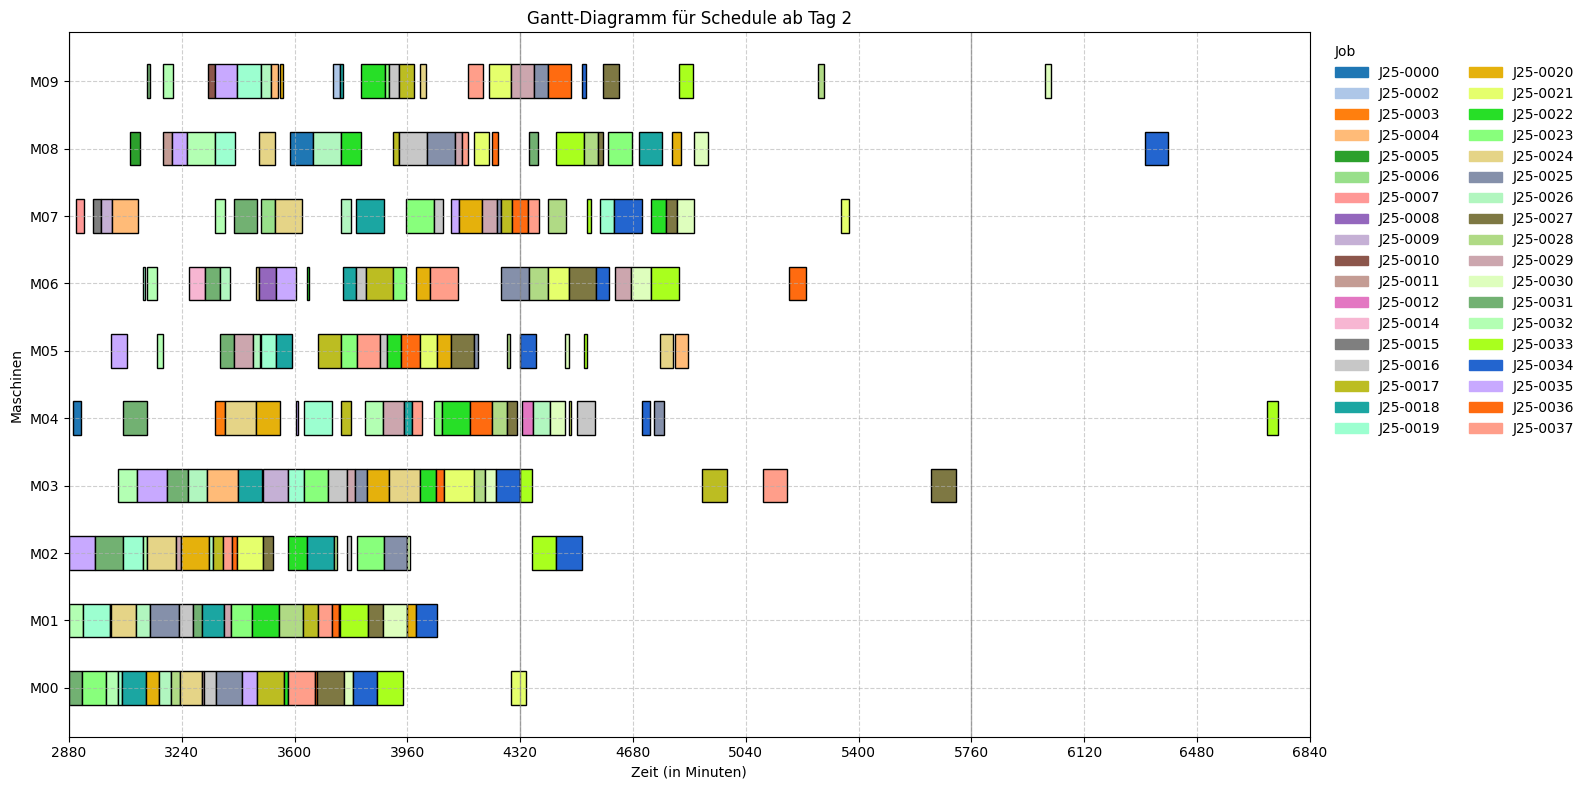

In [19]:
df_schedule = cp_late_reschedule.solve_jssp_by_tardiness_and_earliness_with_fixed_ops(df_jssp_curr, df_jobs_times_curr, 
                                                                                      df_ops_in_progess, w_t = 5,
                                                                                      reschedule_start = day_start, 
                                                                                      msg=False, timeLimit=max_time, gapRel= 0.001)

show.plot_gantt(df_schedule, perspective="Machine", title=f"Gantt-Diagramm für Schedule ab Tag {day_numb}")

In [20]:
schedule_dict = df_schedule.to_dict(orient='records') 
Schedule.add_schedule(data=schedule_dict, date=day_numb,version=this_version)

✅ Schedule hinzugefügt (Version=lateness_simple, Date=2)


In [21]:
check.all_in_one(df_schedule)

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.



True

In [22]:
last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
print(show.count_column_grouped(last_ops, "Lateness", max_val = 240, steps= 60))

label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         1
0              35
0 - 60          0
60 - 120        0
120 - 180       0
180 - 240       0
>240            0
Name: count, dtype: int64


In [23]:
simulation = ProductionSimulation(df_schedule, sigma=0.2)
df_execution = simulation.run(start_time = day_start, end_time=day_end)

[Day 2 00:00:00] Job J25-0031 started on M00
[Day 2 00:00:00] Job J25-0032 started on M01
[Day 2 00:00:00] Job J25-0035 started on M02
[Day 2 00:12:00] Job J25-0000 started on M04
[Day 2 00:24:00] Job J25-0007 started on M07
[Day 2 00:40:41] Job J25-0031 finished on M00 (after 40 minutes 41 seconds)
[Day 2 00:41:06] Job J25-0000 finished on M04 (after 29 minutes 07 seconds)
[Day 2 00:41:54] Job J25-0007 finished on M07 (after 17 minutes 55 seconds)
[Day 2 00:43:00] Job J25-0023 started on M00
[Day 2 00:48:23] Job J25-0032 finished on M01 (after 48 minutes 23 seconds)
[Day 2 00:48:23] Job J25-0019 started on M01
[Day 2 01:16:00] Job J25-0015 started on M07
[Day 2 01:34:06] Job J25-0035 finished on M02 (after 94 minutes 07 seconds)
[Day 2 01:34:06] Job J25-0031 started on M02
[Day 2 01:36:58] Job J25-0015 finished on M07 (after 20 minutes 59 seconds)
[Day 2 01:41:00] Job J25-0009 started on M07
[Day 2 01:42:59] Job J25-0023 finished on M00 (after 59 minutes 59 seconds)
[Day 2 01:48:44] J

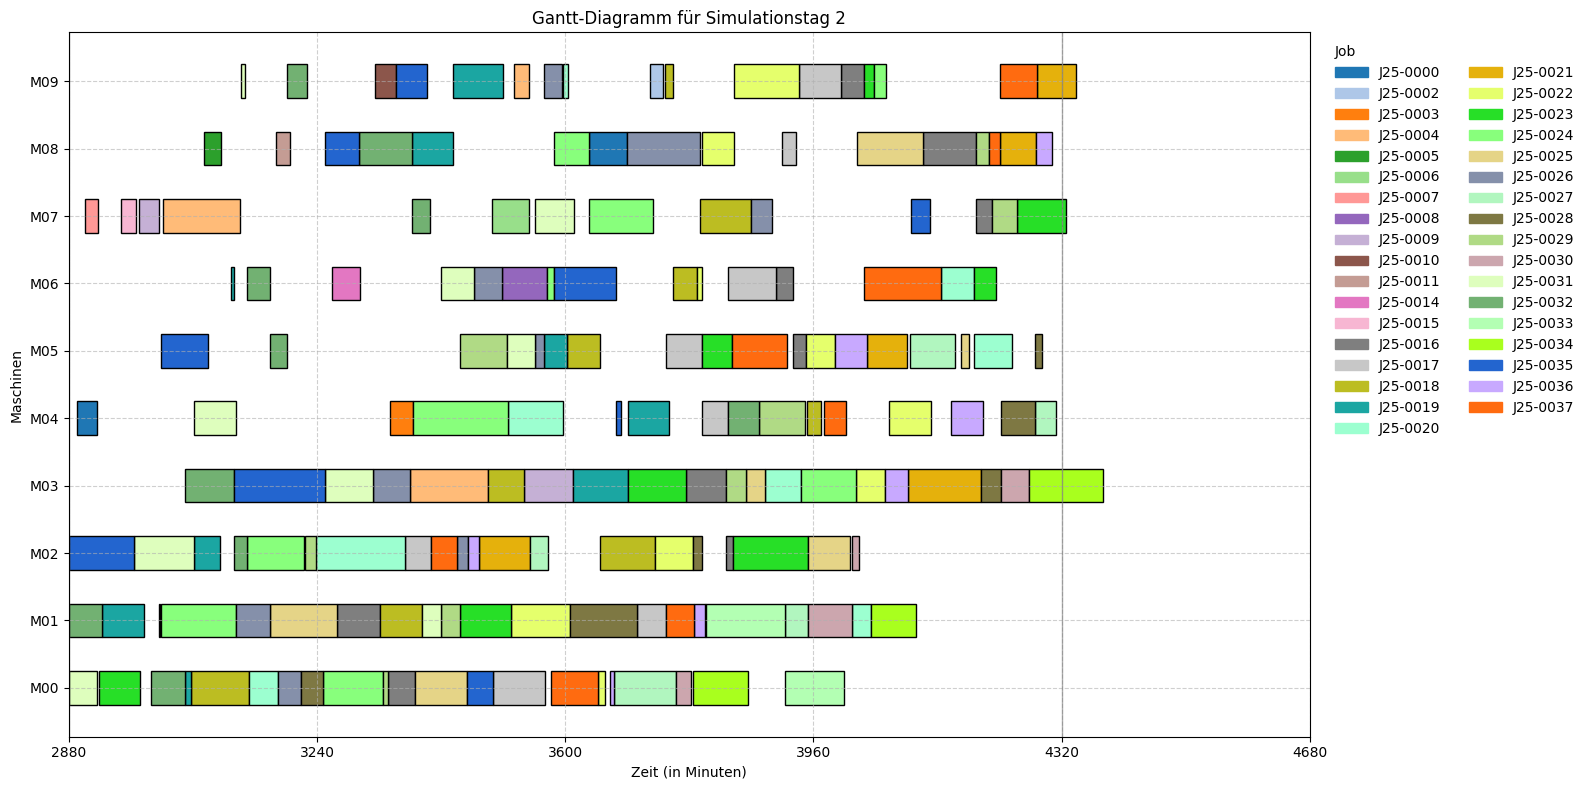

In [24]:
show.plot_gantt(df_execution, perspective="Machine", title=f"Gantt-Diagramm für Simulationstag {day_numb}")

In [25]:
df_ops_finished = df_execution[df_execution.End < day_end]
JobOperation.add_from_dataframe(df_ops_finished, version=this_version, status="finished")
df_ops_finished

✅ 176 JobOperation-Einträge (Version 'lateness_simple', Status 'finished') wurden hinzugefügt oder aktualisiert.


,Job,Routing_ID,Operation,Machine,Arrival,Start,Processing Time,End
0,J25-0000,8,8,M04,79,2892.00,29.11,2921.11
1,J25-0000,8,9,M08,79,3634.18,55.83,3690.01
2,J25-0002,0,9,M09,198,3723.00,18.82,3741.82
3,J25-0003,2,9,M04,243,3346.00,33.86,3379.86
4,J25-0004,3,6,M07,287,3017.00,111.57,3128.57
...,...,...,...,...,...,...,...,...
174,J25-0037,7,3,M05,2801,3842.47,79.28,3921.75
175,J25-0037,7,4,M04,2801,3976.00,30.78,4006.78
176,J25-0037,7,5,M06,2801,4033.00,111.43,4144.43
177,J25-0037,7,6,M08,2801,4215.38,15.49,4230.87


In [26]:
JobOperation.update_closed_jobs_from_operations(version=this_version)

✅ 14 Job(s) wurden auf 'closed' gesetzt (Version 'lateness_simple').


['J25-0001',
 'J25-0002',
 'J25-0003',
 'J25-0005',
 'J25-0007',
 'J25-0008',
 'J25-0009',
 'J25-0010',
 'J25-0011',
 'J25-0013',
 'J25-0014',
 'J25-0015',
 'J25-0032',
 'J25-0035']

In [27]:
df_ops_in_progess = df_execution[df_execution.End >= day_end]
JobOperation.add_from_dataframe(df_ops_in_progess, version=this_version, status="in progress")
df_ops_in_progess

✅ 3 JobOperation-Einträge (Version 'lateness_simple', Status 'in progress') wurden hinzugefügt oder aktualisiert.


,Job,Routing_ID,Operation,Machine,Arrival,Start,Processing Time,End
65,J25-0021,5,5,M09,1952,4283.66,57.41,4341.07
82,J25-0023,8,7,M07,2055,4255.61,70.33,4325.94
153,J25-0034,8,2,M03,2715,4273.33,106.23,4379.56
